# Day 12 – Advanced Boosting: XGBoost Deep Dive

This notebook explores boosting from both a theoretical and practical perspective.

We move beyond API usage and focus on:

- Functional gradient descent intuition
- Bias–variance behavior in boosting
- Regularization mechanisms in XGBoost
- Early stopping and model diagnostics
- Production-style evaluation workflow

The goal is to understand **why XGBoost works**, not just how to run it.

## Boosting as Functional Gradient Descent

Gradient Boosting is not just "sequential trees". It is performing gradient descent in function space.

Instead of updating parameters like in linear regression:

    θ = θ - η ∇L(θ)

Boosting updates the model function:

    F_m(x) = F_{m-1}(x) + η h_m(x)

Where:
- h_m(x) approximates the negative gradient of the loss
- η controls the step size

This means each tree is learning the direction that reduces loss the fastest.

This interpretation explains:
- Why learning rate matters
- Why too many trees can overfit
- Why differentiable loss functions are required

## Why Boosting Works So Well on Tabular Data

Boosting excels because:

- Trees capture nonlinear interactions naturally.
- Sequential learning reduces systematic errors.
- Additive modeling increases expressiveness.
- Regularization controls model complexity.

Unlike linear models, boosting does not assume feature independence.
Unlike deep learning, it does not require massive data.

This makes boosting especially powerful for structured datasets.

## Bias–Variance Behavior in Boosting

Boosting primarily reduces bias.

Why?
- Each new tree corrects systematic errors.
- Errors are reduced sequentially.
- Weak learners combine into a strong learner.

However:
- Too many trees → variance increases
- Deep trees → variance increases
- Large learning rate → unstable updates

Practical Insight:
Small learning rate + many trees + early stopping
gives low bias and controlled variance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

In [2]:
data = fetch_california_housing()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

## Data Splitting Strategy

To ensure unbiased model evaluation, we use a three-way split:

- Training Set → Model learning
- Validation Set → Hyperparameter tuning
- Test Set → Final unbiased evaluation

Important:
The test set is NEVER used during tuning.

This prevents data leakage and ensures reliable performance estimation.

In [3]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

- 64% train
- 16% validation
- 20% test

Evaluation Metrics:
- RMSE (Root Mean Squared Error)
- R² Score

In [4]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("GBR R2:", r2_score(y_test, y_pred_gbr))

GBR RMSE: 0.5229773806931695
GBR R2: 0.7912824581804656


## Learning Rate vs Number of Estimators Tradeoff

There is an inverse relationship:

Small learning rate:
    - Requires more trees
    - Slower learning
    - Better generalization

Large learning rate:
    - Fewer trees needed
    - Faster convergence
    - Higher overfitting risk

In production systems:
    η = 0.01 to 0.1 is common
    n_estimators = large
    early stopping = mandatory

This allows stable convergence and better test performance.

## XGBoost Objective Function

XGBoost optimizes:

    Obj = Σ L(y_i, ŷ_i) + Σ Ω(f_k)

Where regularization term is:

    Ω(f) = γT + (1/2)λ ||w||²

T = number of leaves
w = leaf weights

This penalizes:
- Too many leaves (model complexity)
- Large leaf weights (overconfident predictions)

This explicit regularization is the key reason XGBoost
generalizes better than vanilla Gradient Boosting.

In [12]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    early_stopping_rounds=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)

print("XGB RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("XGB R2:", r2_score(y_test, y_pred_xgb))

XGB RMSE: 0.45460105041135507
XGB R2: 0.8422918962959703


## Overfitting Control in XGBoost

XGBoost provides multiple regularization controls:

- max_depth → limits tree depth
- min_child_weight → prevents small noisy splits
- gamma → minimum split gain threshold
- subsample → row sampling
- colsample_bytree → column sampling
- reg_alpha → L1 regularization
- reg_lambda → L2 regularization
- early_stopping_rounds → stops when validation error increases

This multi-level control makes it production-ready.

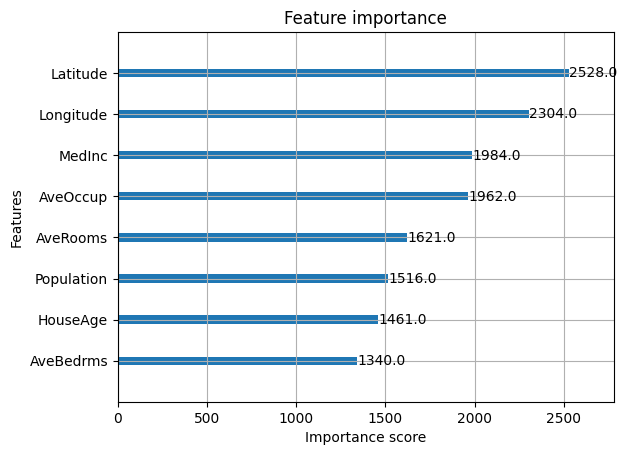

In [13]:
xgb.plot_importance(xgb_model)
plt.show()

## Feature Importance Analysis

Feature importance is computed using the "gain" metric,
which measures the average improvement in loss contributed by each feature.

### Observations

- Median Income (MedInc) contributes the highest gain.
- Geographic features (Latitude, Longitude) are strong predictors.
- Structural housing features have moderate impact.

### Interpretation

Boosted trees automatically capture nonlinear feature interactions.
Higher gain indicates that splits using that feature significantly reduce error.

### Caution

Feature importance does not imply causality.
It reflects predictive contribution within this specific model.

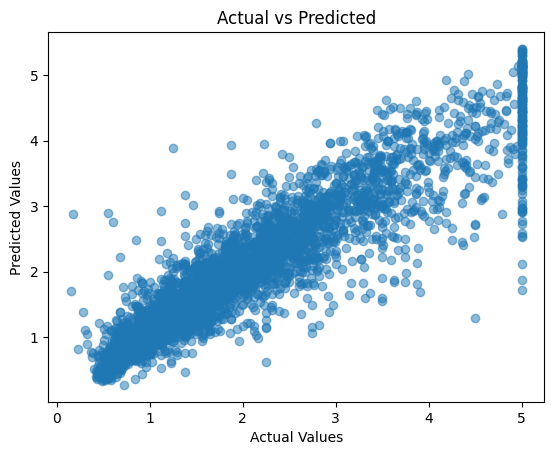

In [14]:
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()

## Actual vs Predicted Values

This scatter plot compares true target values with model predictions.

### Observations

- Points align closely to the diagonal line.
- No severe systematic bias is visible.
- Slight dispersion exists for extreme values.

### Interpretation

Alignment with the diagonal indicates strong predictive performance.
Dispersion increases slightly for high-value homes, suggesting
mild variance in high-price regions.

This confirms the model captures the overall data distribution effectively.

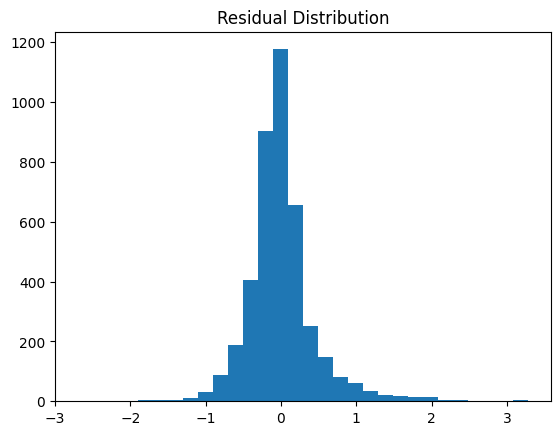

In [15]:
residuals = y_test - y_pred_xgb
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()

## Residual Diagnostics

Residual analysis is crucial for validating regression models.

Observations:

- Residuals are centered around zero → unbiased predictions.
- Distribution is approximately symmetric → balanced errors.
- No extreme skewness → stable predictions across ranges.

If residuals were skewed or heteroscedastic,
it would indicate systematic model miscalibration.

Residual diagnostics confirm that the model behaves consistently
across different target value ranges.

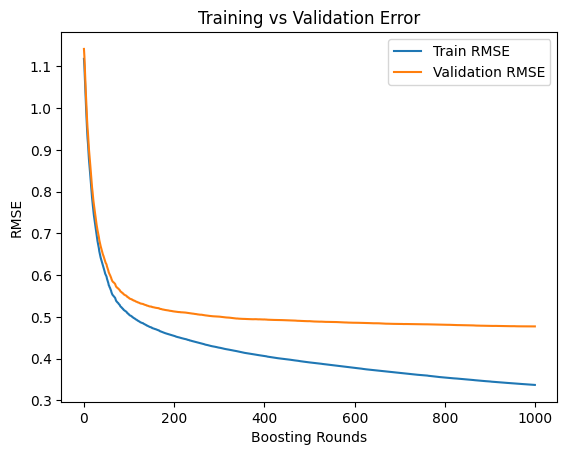

In [16]:
results = xgb_model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

plt.plot(train_rmse, label="Train RMSE")
plt.plot(val_rmse, label="Validation RMSE")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.title("Training vs Validation Error")
plt.show()

## Learning Curve Analysis

The training curve decreases steadily, indicating continuous reduction in bias.

The validation curve initially improves, then stabilizes.

Key diagnostic signals:

- Small gap between curves → controlled variance.
- No sharp validation increase → no severe overfitting.
- Early stopping selects optimal number of trees.

In boosting, monitoring validation error is critical because
training error will always decrease due to additive fitting.

This plot confirms that the model generalizes well.

XGBoost uses second-order gradient optimization, explicit regularization on tree complexity, and built-in subsampling strategies. These reduce overfitting while maintaining low bias, which makes it superior for structured datasets.

## Production Considerations

In real-world ML systems:

- Early stopping prevents overfitting during training.
- Validation set must remain strictly separate from test set.
- Hyperparameters should be tuned using cross-validation.
- Model artifacts should be saved and versioned.
- Feature importance should be logged for interpretability.

This workflow ensures reproducibility, stability, and deployment readiness.